<div align='center'><font size="5" color="#00000"><center><h1 style="text-transform: uppercase; text-shadow: 1px 1px;"> PySaDML </h1></center></font></div> <br>
<div align='center'><font size="4" color="#00000"><center><h1 style="text-transform: uppercase; text-shadow: 1px 1px;"> CNN Model - MFCC features. </h1></center></font></div>

<div align='center'><font size="2" color="#00000"><center><h1 style="text-transform: uppercase; text-shadow: 1px 1px;"> Détection de son anormal dans les pièces industrielles </h1></center></font></div>
<br>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# =============================================================================
# Created By  : Mike G
# Created Date: Thursday Nov 25 15:00:00 UTC 2021
# =============================================================================
# Required libraries
import pandas as pd
import numpy as np

from datetime import datetime
from include import common, models

from pathlib import Path

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#show pandas version
pd.__version__

'1.3.4'

In [2]:
# l'extension du fichier de données a importer.
EXT = '.csv'

# Le répertoire racine des données audio dev_data et eval_data
DATASET_ROOT = './../data'

# Les dossiers dans lesquels se trouvent les audios.
AUDIO_SUBFOLDER = '/dev_data'

# Les dossiers dans lesquels se trouvent les fichiers numpy.
NUMPY_SUBFOLDER = '/numpy_files'

# Les dossiers dans lesquels se trouvent les models.
MODEL_SUBFOLDER = '/models'

DATASET_AUDIO_PATH = Path(DATASET_ROOT + AUDIO_SUBFOLDER)

DATASET_NUMPY_PATH = Path(DATASET_ROOT + NUMPY_SUBFOLDER)

MODELS_PATH    = Path(DATASET_ROOT + MODEL_SUBFOLDER)

# Si le dossier dev_data n'existe pas, le créer, sinon ne rien faire.
Path(DATASET_AUDIO_PATH).mkdir(parents=True, exist_ok=True)

In [3]:
!tree ./{DATASET_AUDIO_PATH}

Structure du dossier
Le numéro de série du volume est 50DF-2547
C:\USERS\GUIDY\DOCUMENTS\GITHUB\PYSADML\DATA\DEV_DATA
+---fan
¦   +---test
¦   +---train
+---pump
¦   +---test
¦   +---train
+---slider
¦   +---test
¦   +---train
+---ToyCar
¦   +---test
¦   +---train
+---ToyConveyor
¦   +---test
¦   +---train
+---valve
    +---test
    +---train


# A - Analyse du type de machine

## 1. Chargement des données

In [4]:
# chargement des données d'entraînement
X_train = np.load(Path(DATASET_NUMPY_PATH, "train_data_mfcc_trunc.npy"))
y_train = np.load(Path(DATASET_NUMPY_PATH, "train_labels_type.npy"))

# Chargement des données de test
X_test = np.load(Path(DATASET_NUMPY_PATH, "test_data_mfcc_trunc.npy"))
y_test = np.load(Path(DATASET_NUMPY_PATH, "test_labels_type.npy")) #libellé des types de machines
y_test_condition = np.load(Path(DATASET_NUMPY_PATH, "test_labels_status.npy")) #libellé du statut des fichiers audios

print("Test split: {} \t\t Train split: {}".format(X_test.shape[0], X_train.shape[0]))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 10868 		 Train split: 20119
X test shape: (10868, 40, 32) 	 X train shape: (20119, 40, 32)
y test shape: (10868,) 		 y train shape: (20119,)


#### 1.1 Encodage des libellés (One hot encode labels)

In [5]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.2 Standardisation des données avant traitement

In [6]:
pipeline = Pipeline([('S', StandardScaler()), ('M', MinMaxScaler())])

X_train = pipeline.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = pipeline.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)


In [7]:
# How data should be structured
NUM_ROWS = X_train.shape[1]
NUM_COLUMNS = X_train.shape[2] 
NUM_CHANNELS = 1

INPUT_SHAPE = (NUM_ROWS, NUM_COLUMNS, NUM_CHANNELS)

# Create label
CLASS_LABELS = le.classes_

# Total number of labels to predict (equal to the network output nodes)
NUM_LABELS = len(CLASS_LABELS)

VALIDATION_DATA = (X_test, y_test_encoded)

#### 1.3 Redimensionnement des données

In [8]:
X_train = X_train.reshape(X_train.shape[0], NUM_ROWS, NUM_COLUMNS, NUM_CHANNELS)
X_test = X_test.reshape(X_test.shape[0], NUM_ROWS, NUM_COLUMNS, NUM_CHANNELS)

print("Test split: {} \t\t\t Train split: {}".format(X_test.shape[0], X_train.shape[0]))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t\t y train shape: {}".format(y_test.shape, y_train.shape))
print("\nNumber of class to predict: {}".format(NUM_LABELS))

Test split: 10868 			 Train split: 20119
X test shape: (10868, 40, 32, 1) 	 X train shape: (20119, 40, 32, 1)
y test shape: (10868,) 			 y train shape: (20119,)

Number of class to predict: 6


## 2. Création du modèle

In [9]:
# Ces paramètres sont utilisés pour extraire valeurs mel ou mfcc.
n_mels = 64
n_mfcc = 40
n_fft = 2**13
hop_length = 2**11

# Define hyper-parameters
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-05
MOMENTUM = 0.9

sec_max = 4.0

In [10]:
model_file = 'cnn_mfcc_type.hdf5'
model_path = Path(MODELS_PATH, model_file)

#### 2.1 Définition du modèle

In [11]:
model = models.cnn_simple_model(shape=INPUT_SHAPE, num_labels=NUM_LABELS)

# Display model architecture summary 
model.summary()

Model: "cnn_simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 20, 16, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 16, 64)        18496     
                                                                 
 average_pooling2d (AverageP  (None, 10, 8, 64)   

#### 2.2 Configuration de l'optimiseur de modèle et de la fonction de perte

In [12]:
# Compile model
OPTIMIZER = SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
LOSS = 'categorical_crossentropy'
METRICS = 'accuracy'

model.compile(
    loss=LOSS, 
    optimizer=OPTIMIZER, 
    metrics=[METRICS])

#### 2.3 Fit du modèle

In [13]:
start = datetime.now()

# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               save_best_only=True)

# Save learning rate
reduce_lr = ReduceLROnPlateau(patience=3,
                              cooldown=5,
                              min_lr=1e-5)

# interrupt the training process when the validation loss is no longer improving
early_stop = EarlyStopping(min_delta=1e-6, 
                           patience=15, 
                           verbose=1, 
                           restore_best_weights=True)

history = model.fit(X_train, y_train_encoded,
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=[checkpointer, reduce_lr, early_stop],
                    validation_data=VALIDATION_DATA,
                    use_multiprocessing=True,
                    shuffle=True)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
629/629 [==============================] - 19s 30ms/step - loss: 1.3604 - accuracy: 0.4966 - val_loss: 0.9031 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 2/50
629/629 [==============================] - 20s 32ms/step - loss: 0.8242 - accuracy: 0.6890 - val_loss: 0.4703 - val_accuracy: 0.8325 - lr: 1.0000e-05
Epoch 3/50
629/629 [==============================] - 18s 29ms/step - loss: 0.6933 - accuracy: 0.7407 - val_loss: 0.4182 - val_accuracy: 0.8485 - lr: 1.0000e-05
Epoch 4/50
629/629 [==============================] - 18s 29ms/step - loss: 0.6229 - accuracy: 0.7657 - val_loss: 0.3904 - val_accuracy: 0.8567 - lr: 1.0000e-05
Epoch 5/50
629/629 [==============================] - 19s 30ms/step - loss: 0.5725 - accuracy: 0.7857 - val_loss: 0.3727 - val_accuracy: 0.8604 - lr: 1.0000e-05
Epoch 6/50
629/629 [==============================] - 19s 30ms/step - loss: 0.5389 - accuracy: 0.7983 - val_loss: 0.3590 - val_accuracy: 0.8659 - lr: 1.0000e-05
Epoch 7/50
629/629 [==============

#### 2.4 Evaluation du meilleur modèle

In [14]:
# Load best saved model
model = load_model(model_path)

In [15]:
# Evaluate metrics
models.model_metric_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.2471        91.42%
Test:             0.2454        91.22%
--------------------------------------

Error rate         0.70% 


#### 2.5 Graphiques

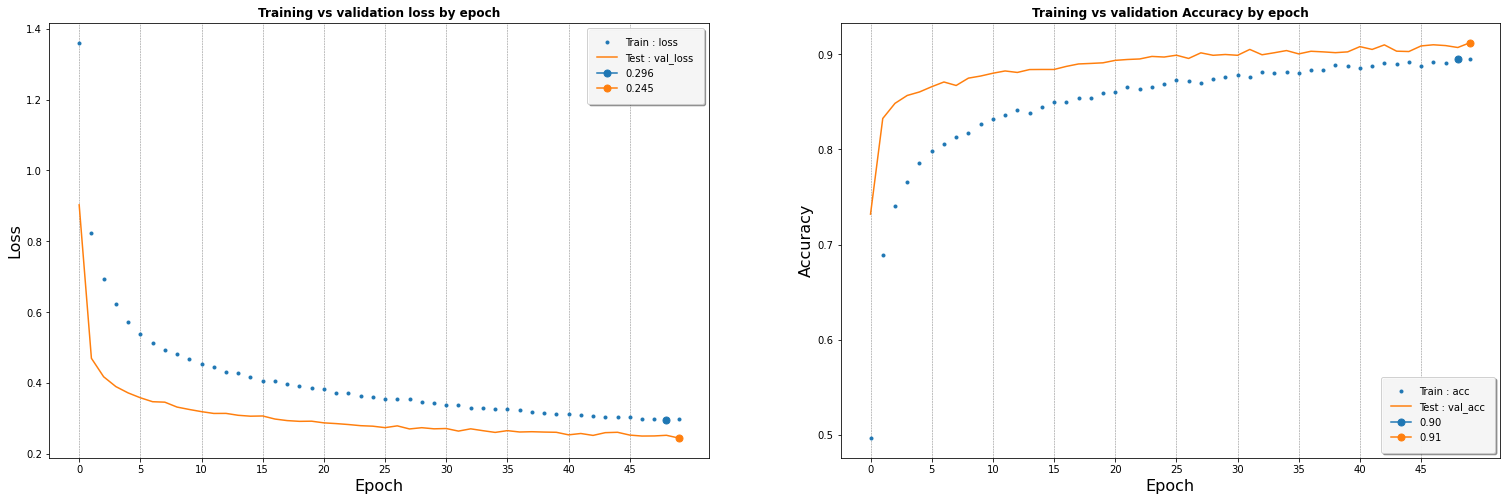

In [16]:
models.plot_model_history(history, ylabel_metric='Accuracy', metrics=METRICS, size=(26,8))

### 3. Evaluation du modèle

In [17]:
Y_predict = model.predict(X_test)

Y_predict_class = Y_predict.argmax(axis = 1)
Y_class = y_test_encoded.argmax(axis = 1)

#### 3.1 Confusion matrix

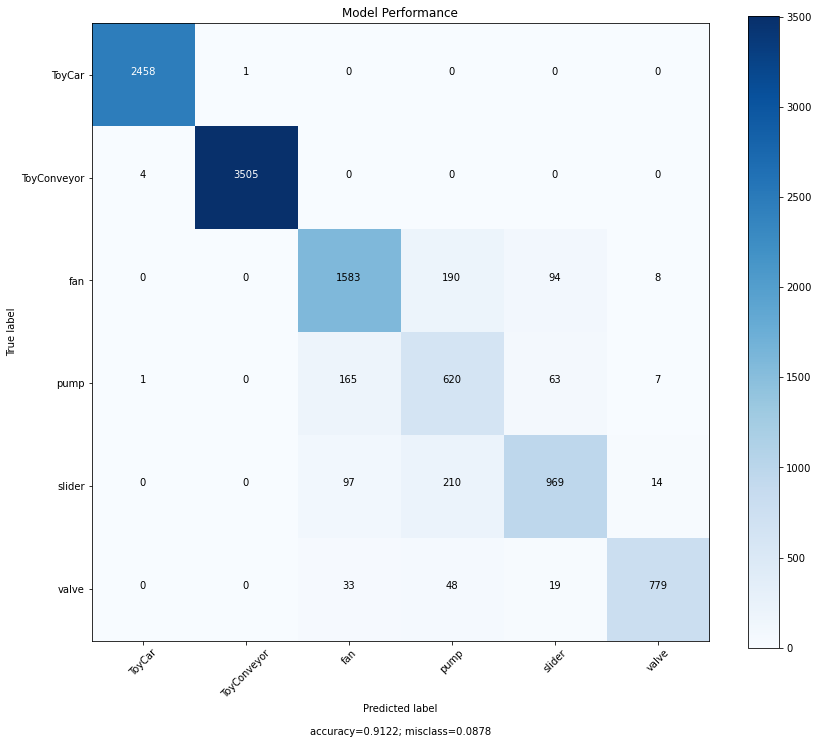

In [18]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

models.plot_confusion_matrix(y_true=Y_class, y_pred=Y_predict_class, class_label=CLASS_LABELS, title="Model Performance",size=(12,10))

#### 3.2 Tableau de précision du modèle

In [19]:
models.target_metric_report(Y_class, Y_predict_class, CLASS_LABELS)

,CLASS,ACCURACY
0,ToyCar,99.96%
1,ToyConveyor,99.89%
5,valve,88.62%
2,fan,84.43%
4,slider,75.12%
3,pump,72.43%


#### 3.3 Performance de classification : scores de Presicion, Recall et F1

In [20]:
print(classification_report(Y_class, Y_predict_class, target_names=CLASS_LABELS))

              precision    recall  f1-score   support

      ToyCar       1.00      1.00      1.00      2459
 ToyConveyor       1.00      1.00      1.00      3509
         fan       0.84      0.84      0.84      1875
        pump       0.58      0.72      0.64       856
      slider       0.85      0.75      0.80      1290
       valve       0.96      0.89      0.92       879

    accuracy                           0.91     10868
   macro avg       0.87      0.87      0.87     10868
weighted avg       0.92      0.91      0.91     10868



#### 3.4 Prédiction du modèle

* un exemple de prédiction audio

In [21]:
def pred_and_plot(file_path, hop_length=hop_length, n_mels=n_mels, n_mfcc=n_mfcc, duration=4.0):
    mfccs, sr = common.get_mfcc(file_path, hop_length, n_mels, n_mfcc, duration=duration)
    mfccs = mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1)
    # Make a prediction
    pred = model.predict(tf.expand_dims(mfccs, axis=0))    
    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = CLASS_LABELS[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = CLASS_LABELS[int(tf.round(pred)[0][0])] # if only one output, round
    print(f"Prediction: {pred_class}")
    print(f"-------------------------")
    return common.display_audio(file_path)

Prediction: slider
-------------------------
Fichier:  ..\data\test_audio_files\fan_id_01_00000010.wav
Fréquence d'échantillonnage: 16000
Durée: 10.0 seconds


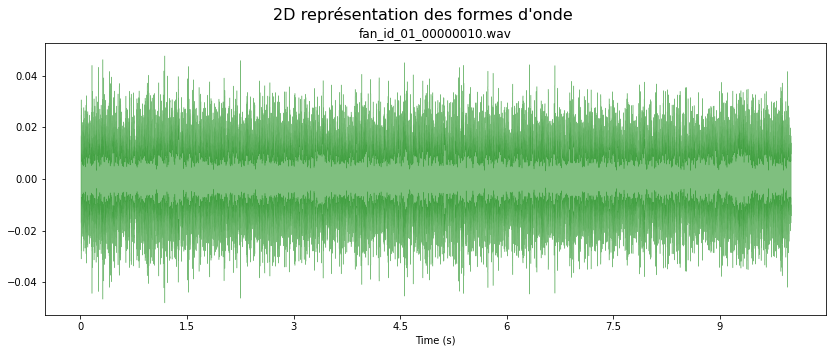

In [22]:
# Test our model on a custom image
file_path="./../data/test_audio_files/fan_id_01_00000010.wav"
pred_and_plot(file_path, hop_length=hop_length, n_mels=n_mels, n_mfcc=n_mfcc, duration=sec_max)

* crosstab

In [23]:
y_test_condition = np.load(Path(DATASET_NUMPY_PATH, "test_labels_status.npy"))
df_pred_cond = pd.DataFrame(np.vstack((y_test, y_test_condition, Y_class, Y_predict_class))).T
df_pred_cond.columns = ['label', 'condition', 'machine_type', 'Predict_type']
df_pred_cond.loc[df_pred_cond['machine_type'] == df_pred_cond['Predict_type'], 'Predict_condition'] = 'normal'  
df_pred_cond.loc[df_pred_cond['machine_type'] != df_pred_cond['Predict_type'], 'Predict_condition'] = 'anomaly'
pd.crosstab(df_pred_cond.condition, df_pred_cond.Predict_condition, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,anomaly,normal
Classe réelle,,
anomaly,722,4747
normal,232,5167


In [24]:
pd.crosstab(index=[df_pred_cond.label, df_pred_cond.condition], columns=df_pred_cond.Predict_condition)

Predict_condition      anomaly  normal
label       condition                 
ToyCar      anomaly          0    1059
            normal           1    1399
ToyConveyor anomaly          3    1107
            normal           1    2398
fan         anomaly        248    1227
            normal          44     356
pump        anomaly        185     271
            normal          51     349
slider      anomaly        219     671
            normal         102     298
valve       anomaly         67     412
            normal          33     367

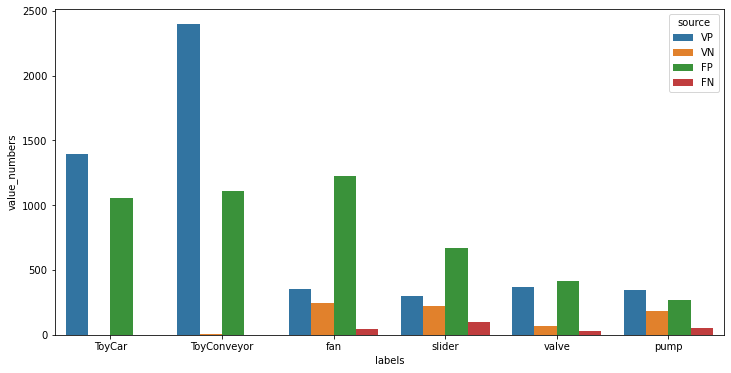

In [25]:
colonne = df_pred_cond.label.unique().tolist()

dict_analyse = {}
VP, VN, FP, FN = [], [], [], []
for col in colonne:
    VP.append (df_pred_cond [(df_pred_cond['condition'] == "normal" ) & (df_pred_cond['Predict_condition'] == "normal") & (df_pred_cond['label'] == col) ].shape[0])
    VN.append (df_pred_cond [(df_pred_cond['condition'] == "anomaly" ) & (df_pred_cond['Predict_condition'] == "anomaly") & (df_pred_cond['label'] == col) ].shape[0])
    FP.append (df_pred_cond [(df_pred_cond['condition'] == "anomaly" ) & (df_pred_cond['Predict_condition'] == "normal") & (df_pred_cond['label'] == col) ].shape[0])
    FN.append (df_pred_cond [(df_pred_cond['condition'] == "normal" ) & (df_pred_cond['Predict_condition'] == "anomaly") & (df_pred_cond['label'] == col) ].shape[0])
    
dict_analyse ['labels'] = colonne
dict_analyse ['VP'] = VP
dict_analyse ['VN'] = VN
dict_analyse ['FP'] = FP
dict_analyse ['FN'] = FN

analyse = pd.DataFrame(dict_analyse)

columns = ["labels", "VP", "VN", "FP", "FN"]
analyse_melted = pd.melt(analyse, id_vars=columns[0], var_name="source", value_name="value_numbers")
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x=columns[0], y="value_numbers", hue="source", data=analyse_melted)
plt.show()

## 4. Modèle LeNet

In [31]:
model_file = 'LeNet_mfcc.hdf5'
model_path = Path(MODELS_PATH, model_file)

In [32]:
model = models.LeNet_model(shape=INPUT_SHAPE, num_labels=NUM_LABELS)

# Display model architecture summary 
model.summary()

Model: "LeNet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 12, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 6, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               

In [33]:
# Compile model
OPTIMIZER = Adam()
LOSS = 'categorical_crossentropy'
METRICS = 'accuracy'

model.compile(
    loss=LOSS, 
    optimizer=OPTIMIZER, 
    metrics=[METRICS])

In [34]:
start = datetime.now()

# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               save_best_only=True)

# Save learning rate
reduce_lr = ReduceLROnPlateau(patience=3,
                              cooldown=5,
                              min_lr=1e-5)

# interrupt the training process when the validation loss is no longer improving
early_stop = EarlyStopping(min_delta=1e-6, 
                           patience=15, 
                           verbose=1, 
                           restore_best_weights=True)

history = model.fit(X_train, y_train_encoded,
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=[checkpointer, reduce_lr, early_stop],
                    validation_split = 0.2,
                    shuffle=True)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
503/503 [==============================] - 7s 14ms/step - loss: 0.7658 - accuracy: 0.6999 - val_loss: 0.4570 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 2/50
503/503 [==============================] - 6s 13ms/step - loss: 0.4230 - accuracy: 0.8380 - val_loss: 0.3929 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 3/50
503/503 [==============================] - 7s 13ms/step - loss: 0.3765 - accuracy: 0.8568 - val_loss: 0.3468 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 4/50
503/503 [==============================] - 9s 17ms/step - loss: 0.3508 - accuracy: 0.8701 - val_loss: 0.3267 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 5/50
503/503 [==============================] - 8s 15ms/step - loss: 0.3221 - accuracy: 0.8805 - val_loss: 0.3310 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 6/50
503/503 [==============================] - 7s 14ms/step - loss: 0.3068 - accuracy: 0.8874 - val_loss: 0.3024 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 7/50
503/503 [==============================] - 7s 13ms/st

In [35]:
# Load best saved model
model = load_model(model_path)
# Evaluate metrics
models.model_metric_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.0964        96.76%
Test:             0.2909        90.91%
--------------------------------------

Error rate        66.86% 


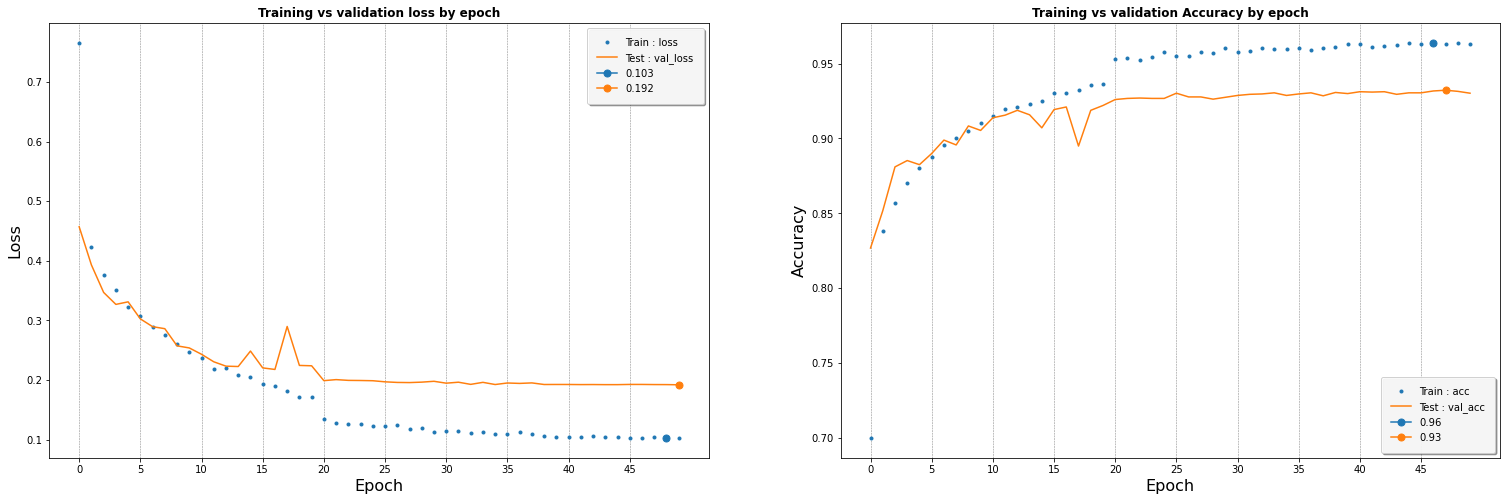

In [36]:
models.plot_model_history(history, ylabel_metric='Accuracy', metrics=METRICS, size=(26,8))

In [37]:
# Predict probabilities for test set
Y_predict = model.predict(X_test)

# Get predicted labels
Y_predict_class = Y_predict.argmax(axis = 1)
Y_class = y_test_encoded.argmax(axis = 1)

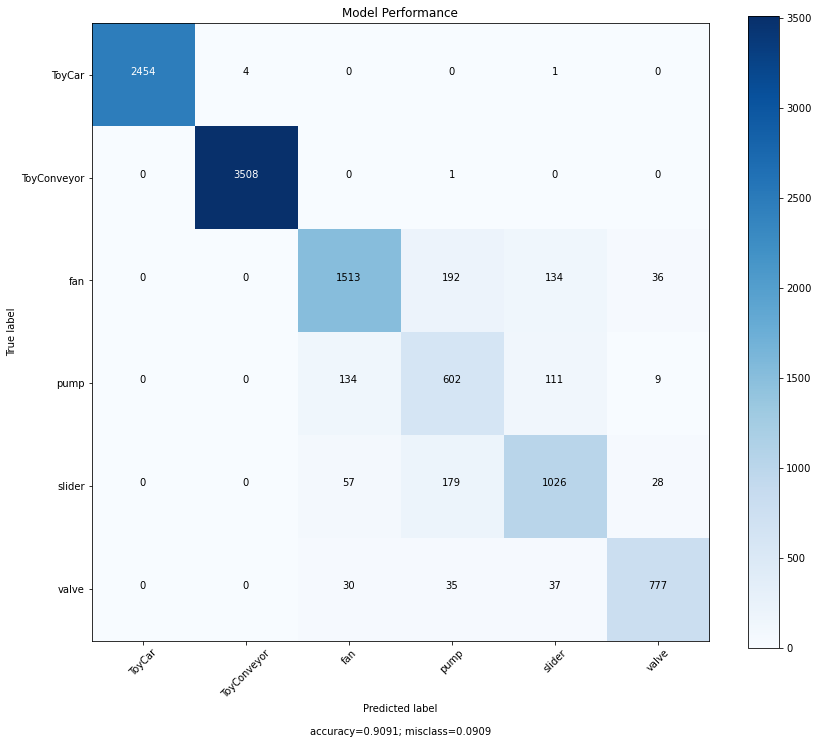

In [38]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

models.plot_confusion_matrix(y_true=Y_class, y_pred=Y_predict_class, class_label=CLASS_LABELS, title="Model Performance",size=(12,10))

In [39]:
models.target_metric_report(Y_class, Y_predict_class, CLASS_LABELS)

,CLASS,ACCURACY
1,ToyConveyor,99.97%
0,ToyCar,99.80%
5,valve,88.40%
2,fan,80.69%
4,slider,79.53%
3,pump,70.33%


In [40]:
print(classification_report(Y_class, Y_predict_class, target_names=CLASS_LABELS))


              precision    recall  f1-score   support

      ToyCar       1.00      1.00      1.00      2459
 ToyConveyor       1.00      1.00      1.00      3509
         fan       0.87      0.81      0.84      1875
        pump       0.60      0.70      0.65       856
      slider       0.78      0.80      0.79      1290
       valve       0.91      0.88      0.90       879

    accuracy                           0.91     10868
   macro avg       0.86      0.86      0.86     10868
weighted avg       0.91      0.91      0.91     10868



Prediction: fan
-------------------------
Fichier:  ..\data\test_audio_files\fan_id_01_00000010.wav
Fréquence d'échantillonnage: 16000
Durée: 10.0 seconds


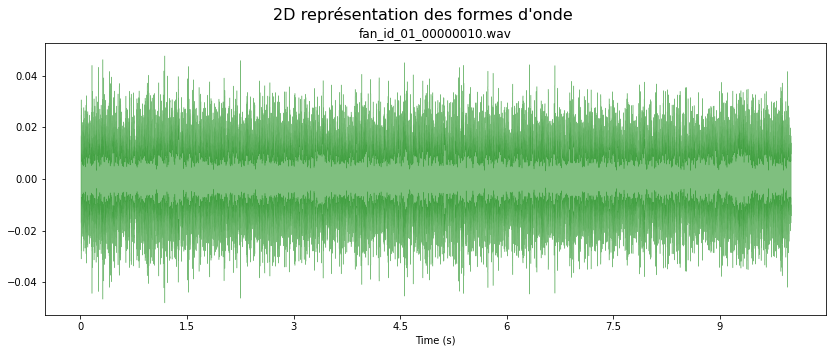

In [41]:
# Test our model on a custom image
file_path="./../data/test_audio_files/fan_id_01_00000010.wav"
pred_and_plot(file_path, hop_length=hop_length, n_mels=n_mels, n_mfcc=n_mfcc, duration=sec_max)

In [42]:
y_test_condition = np.load(Path(DATASET_NUMPY_PATH, "test_labels_status.npy"))
df_pred_cond = pd.DataFrame(np.vstack((y_test, y_test_condition, Y_class, Y_predict_class))).T
df_pred_cond.columns = ['label', 'condition', 'machine_type', 'Predict_type']
df_pred_cond.loc[df_pred_cond['machine_type'] == df_pred_cond['Predict_type'], 'Predict_condition'] = 'normal'  
df_pred_cond.loc[df_pred_cond['machine_type'] != df_pred_cond['Predict_type'], 'Predict_condition'] = 'anomaly'
pd.crosstab(df_pred_cond.condition, df_pred_cond.Predict_condition, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,anomaly,normal
Classe réelle,,
anomaly,815,4654
normal,173,5226


In [43]:
pd.crosstab(index=[df_pred_cond.label, df_pred_cond.condition], columns=df_pred_cond.Predict_condition)

Predict_condition      anomaly  normal
label       condition                 
ToyCar      anomaly          1    1058
            normal           4    1396
ToyConveyor anomaly          1    1109
            normal           0    2399
fan         anomaly        335    1140
            normal          27     373
pump        anomaly        195     261
            normal          59     341
slider      anomaly        214     676
            normal          50     350
valve       anomaly         69     410
            normal          33     367

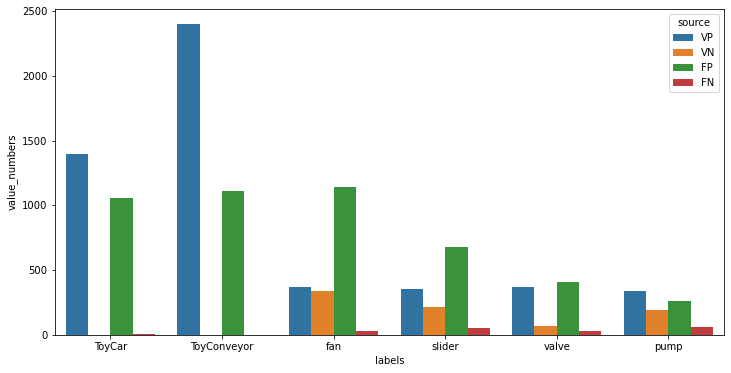

In [44]:
colonne = df_pred_cond.label.unique().tolist()

dict_analyse = {}
VP, VN, FP, FN = [], [], [], []
for col in colonne:
    VP.append (df_pred_cond [(df_pred_cond['condition'] == "normal" ) & (df_pred_cond['Predict_condition'] == "normal") & (df_pred_cond['label'] == col) ].shape[0])
    VN.append (df_pred_cond [(df_pred_cond['condition'] == "anomaly" ) & (df_pred_cond['Predict_condition'] == "anomaly") & (df_pred_cond['label'] == col) ].shape[0])
    FP.append (df_pred_cond [(df_pred_cond['condition'] == "anomaly" ) & (df_pred_cond['Predict_condition'] == "normal") & (df_pred_cond['label'] == col) ].shape[0])
    FN.append (df_pred_cond [(df_pred_cond['condition'] == "normal" ) & (df_pred_cond['Predict_condition'] == "anomaly") & (df_pred_cond['label'] == col) ].shape[0])
    
dict_analyse ['labels'] = colonne
dict_analyse ['VP'] = VP
dict_analyse ['VN'] = VN
dict_analyse ['FP'] = FP
dict_analyse ['FN'] = FN

analyse = pd.DataFrame(dict_analyse)

columns = ["labels", "VP", "VN", "FP", "FN"]
analyse_melted = pd.melt(analyse, id_vars=columns[0], var_name="source", value_name="value_numbers")
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x=columns[0], y="value_numbers", hue="source", data=analyse_melted)
plt.show()